In [1]:
import pandas as pd
import numpy as np

In [2]:
data=pd.read_csv(f'../03.dataset/NTPC_model_features_clean.csv')

In [3]:
data_class = pd.get_dummies(data['鄉鎮市區'])
#data = data.loc[data['交易標的'] == 0]
data_class.columns = ['鄉鎮市區_' + str(x) for x in data_class.columns]
data = pd.concat([data, data_class], axis = 1)
print(data.shape[1])

131


In [4]:
data.insert(data.shape[1], 'y', data['單價元平方公尺'])
data.drop(['單價元平方公尺'],axis=1,inplace=True)
data.drop(['Unnamed: 0'],axis=1,inplace=True)
data.drop(['Unnamed: 0.1'],axis=1,inplace=True)
data.drop(['Unnamed: 0.2'],axis=1,inplace=True)
data.drop(['鄉鎮市區'],axis=1,inplace=True)
#data = data.loc[data['備註'].isnull()]
#data.drop(['備註'],axis=1,inplace=True)
data.drop(['geometry'],axis=1,inplace=True)

In [5]:
data = data.loc[:, data.std() > 0.2]
data = data.dropna()

In [6]:
test_data = data.loc[data['交易年份'] >= 111]
train_data =  data.loc[data['交易年份'] < 111]

In [7]:
feature_count = data.shape[1]

In [8]:
mean = train_data.mean()
std = train_data.std()
train_data = (train_data-mean)/std

In [9]:
X_train = np.array(train_data.drop('y', axis='columns'))
y_train = np.array(train_data['y'])

In [10]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

In [11]:
model_mlp = MLPRegressor(random_state=14,max_iter = 400, activation='relu', hidden_layer_sizes=(int(data.shape[1]*1/2),int(data.shape[1]*1/4)))
model_mlp.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=400, random_state=14)

In [12]:
model_rf = RandomForestRegressor(n_estimators=20,max_depth=90,min_samples_leaf=3)
model_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=90, min_samples_leaf=3, n_estimators=20)

In [13]:
def mix_predictions(Features):
    return ((0.5 * model_mlp.predict(Features)) + (0.5 * model_rf.predict(Features)))

In [14]:
test_data = (test_data - mean) / std
#test_data = test_data.loc[test_data['y'] >= 3]
X_test = np.array(test_data.drop('y', axis='columns'))
y_test = np.array(test_data['y'])

In [15]:
result = mix_predictions(X_test)

In [16]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': result})
df1 = df.head(10)
df1

,Actual,Predicted
0,0.603101,0.622798
1,2.337506,2.265033
2,-0.000451,0.173260
3,-1.799081,-1.839411
4,-1.353926,-0.937370
5,2.903241,1.601552
6,-0.517908,-0.210727
7,0.552110,0.730903
8,0.015082,-0.013094
9,-0.215026,-0.232992


C:\Users\tazz4\anaconda3\envs\ox\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

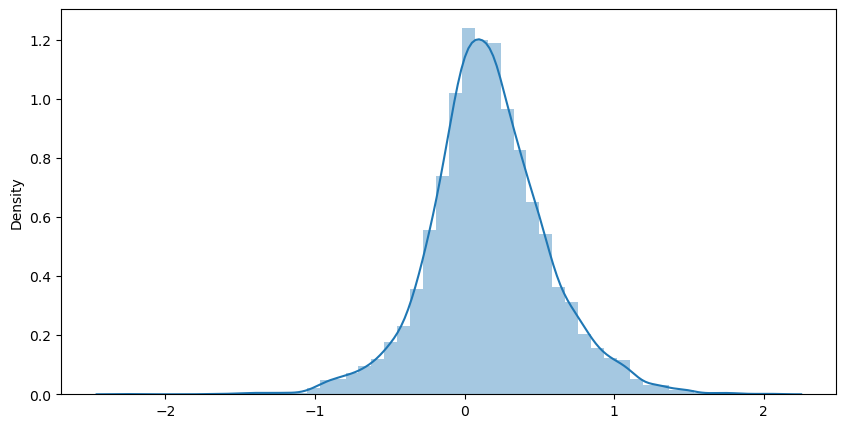

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(10,5))
residuals = (y_test- result)
sns.distplot(residuals)

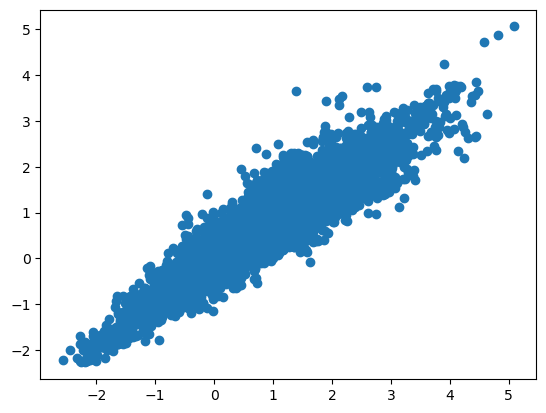

In [18]:
plt.scatter(y_test, result)
plt.plot([0,1],[0,1])

In [19]:
data1 = pd.DataFrame({'origin':y_test * std['y'] + mean['y'],'predict':result* std['y'] + mean['y'],
                     'residual':(y_test * std['y'] + mean['y']) - (result* std['y'] + mean['y'])})
percentage_error = np.mean(np.abs(data1['origin'] - data1['predict'])) / np.mean(data1['origin']) * 100
data1['residual_abs'] = data1['residual'].abs()
data1['y10'] = data1['origin'] / 10 - data1['residual_abs']
data1['y20'] = data1['origin'] / 5 - data1['residual_abs']
data1['y30'] = data1['origin'] / 3.333 - data1['residual_abs']
data1.loc[data1['y10'] >= 0, 'y10'] = 1
data1.loc[data1['y10'] < 0 , 'y10'] = 0
data1.loc[data1['y20'] >= 0, 'y20'] = 1
data1.loc[data1['y20'] < 0 , 'y20'] = 0
data1.loc[data1['y30'] >= 0, 'y30'] = 1
data1.loc[data1['y30'] < 0 , 'y30'] = 0
print(data1)
print(f'預測房價落在實際房價+-10%內的機率為:{data1["y10"].mean()}')
print(f'預測房價落在實際房價+-20%內的機率為:{data1["y20"].mean()}')
print(f'預測房價落在實際房價+-30%內的機率為:{data1["y30"].mean()}')
print("Model Percentage Error: {:.2f}%".format(percentage_error))

        origin        predict      residual  residual_abs  y10  y20  y30
0     111940.0  112608.278987   -668.278987    668.278987  1.0  1.0  1.0
1     170784.0  168325.204923   2458.795077   2458.795077  1.0  1.0  1.0
2      91463.0   97356.592749  -5893.592749   5893.592749  1.0  1.0  1.0
3      30440.0   29071.707123   1368.292877   1368.292877  1.0  1.0  1.0
4      45543.0   59675.677055 -14132.677055  14132.677055  0.0  0.0  0.0
...        ...            ...           ...           ...  ...  ...  ...
8022  115590.0   98456.608511  17133.391489  17133.391489  0.0  1.0  1.0
8023  132443.0  117012.500919  15430.499081  15430.499081  0.0  1.0  1.0
8024  121065.0  102965.492045  18099.507955  18099.507955  0.0  1.0  1.0
8025  179111.0  180654.383184  -1543.383184   1543.383184  1.0  1.0  1.0
8026  158356.0  134567.829346  23788.170654  23788.170654  0.0  1.0  1.0

[8027 rows x 7 columns]
預測房價落在實際房價+-10%內的機率為:0.5984801295627258
預測房價落在實際房價+-20%內的機率為:0.9041983306341099
預測房價落在實際房價+-30%內的機率

In [20]:
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
print(f"mean_absolute_error: {mean_absolute_error(y_test, result)}")
print(f"mean_absolute_percentage_error: {mean_absolute_percentage_error(y_test, result)}")
print(f"mean_squared_error: {mean_squared_error(y_test, result)}")
print(f"explained_variance_score: {explained_variance_score(y_test, result)}")
print(f"r2_score: {r2_score(y_test, result)}")

mean_absolute_error: 0.32036701875531354
mean_absolute_percentage_error: 2.28114682685871
mean_squared_error: 0.18041668484504145
explained_variance_score: 0.8811932321167066
r2_score: 0.8614549671765609
